<a href="https://colab.research.google.com/github/kirath2205/Machine-Learning-Plant-seedling/blob/main/inception_resnet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the required libraries

In [21]:
import tensorflow as tf
import pandas as pd
import numpy as np

#Creating a function to perform image augmentation and create generators for training , validation and testing. The train and validation generators have a validation split of 0.05, that is , 95% of the data is reserved for training and rest 5% of the data is used for validation

In [22]:
def define_generator():
  height = 299
  width = 299
  batch_size = 32
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360,width_shift_range=0.3,height_shift_range=0.3,shear_range=0.3,zoom_range=0.5,vertical_flip=True,horizontal_flip=True,validation_split=0.08,)
  train_generator = train_datagen.flow_from_directory(directory='Documents/train',target_size=(299, 299),batch_size=32,color_mode='rgb',class_mode="categorical",subset='training',)
  validation_generator = train_datagen.flow_from_directory(directory='Documents/train',target_size=(width, height),batch_size=32,color_mode='rgb',class_mode="categorical",subset='validation',)
  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
  test_generator = test_datagen.flow_from_directory(directory='Documents/',classes=['test'],target_size=(299, 299),batch_size=1,color_mode='rgb',shuffle=False,class_mode='categorical')
  return train_generator, validation_generator, test_generator


#Creating a function to define the model for our problem. Here we use inception-resent model which was trained on imagenet dataset. We then add some more layers after importing the model.

In [23]:
def define_model(width, height):
    input = tf.keras.layers.Input(shape=(width, height, 3), name='image_input')
    main = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')(input)
    dense1 = tf.keras.layers.Flatten()(main)
    dense2 = tf.keras.layers.Dense(256, activation='relu')(dense1)
    output = tf.keras.layers.Dense(12, activation="softmax")(dense2)
    model = tf.keras.models.Model(input,  output)
    opt = tf.keras.optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

#Training the model on training data and validating using validation data. Added 3 callbacks - Model checkpoint(to save the best model in terms of validation accuracy), learning rate decay(monitoring validation loss with patience 3) , EarlyStopping (monitoring validation loss with patience 20)

In [ ]:
model = define_model(299, 299)
train_generator, validation_generator, test_generator = define_generator()

history = model.fit(
    train_generator,epochs = 100,steps_per_epoch = train_generator.samples // 32,validation_data = validation_generator,validation_steps = validation_generator.samples // 32,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model_inception_resnet_plant_seedlings_final', monitor='val_accuracy', verbose=1, save_best_only=True),
               tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5,
                              patience = 3, min_lr = 1e-10, verbose = 1, cooldown = 1),
               tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 1e-2, patience = 20, verbose = 1,
               mode = 'min', baseline = None, restore_best_weights = True)
    ]
)

#Creating the plots for accuracy and loss ( train and validation ) over the total epochs during training

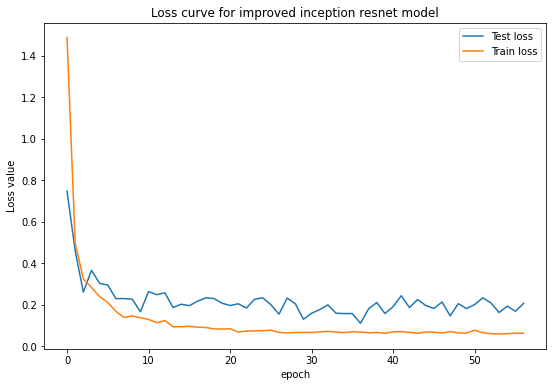

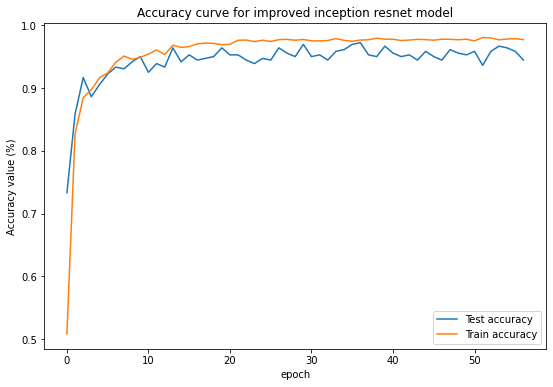

In [27]:
import matplotlib.pyplot as plt

#Plot history: Loss
plt.figure(figsize = (9,6))
plt.plot(history.history['val_loss'],label='Test loss')
plt.plot(history.history['loss'],label='Train loss')
plt.title('Loss curve for improved inception resnet model')
plt.ylabel('Loss value')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Plot history: Accuracy
plt.figure(figsize = (9,6))
plt.plot(history.history['val_accuracy'],label = 'Test accuracy')
plt.plot(history.history['accuracy'],label = 'Train accuracy')
plt.title('Accuracy curve for improved inception resnet model')
plt.ylabel('Accuracy value (%)')
plt.xlabel('epoch')
plt.legend()
plt.show()

#Loading the weights of the best model and making the predictions of the images in the test data and then creating a final csv for submission in the kaggle competition.

In [26]:
model = tf.keras.models.load_model('best_model_inception_resnet_plant_seedlings_final')
seedlings_types = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]
predictions = model.predict(test_generator, steps=test_generator.samples)

class_list = []

for i in range(0, predictions.shape[0]):
  class_list += [seedlings_types[predictions[i, :].argmax(axis=-1)]]

submission = pd.DataFrame()
submission['file'] = test_generator.filenames
submission['file'] = submission['file'].str.replace(r'test/', '')
submission['species'] = class_list

submission.to_csv('inception-resnet.csv', index=False)